# 14 Cross-Countries Retweets - Analysis
In this notebook we analyse the cross-border retweets, i.e., users from one country retweeting users from another country.

We do it in two ways:
- counting absolute number of retweets between each pairs of countries
- normalizing the adjacency matrix of the retweets between countries above, comparing the retweets between countries with the retweets obtained if nodes had the same strength and edges were random (random baseline context)

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from matplotlib.colors import LogNorm, ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#data on edges and users are stored in this folder
folder_DATA = "/data/public/jlenti/multilang-vax/DATA_clean_url"
folder = "/data/public/jlenti/multilang-vax/EuropeAmerica_RTCO"

#list of all countries (size ordered)
countries = ["US", "BR", "AR", "GB", "ES", "MX", "FR", "CA", "TR", "VE", "AU", "CO", "IT", "CL", "DE",
             "PT", "IE", "PY", "EC", "RU", "UY", "NZ", "PL", "NL", "PE", "CU", "PA", "GR"]
#sorted by language
lang_sort = ["US", "IE", "GB", "CA", "NZ", "AU", "FR", "IT", "PL", "NL", "DE", "RU", "TR", 
             "BR", "PT", "GR", "AR", "ES", "MX","VE", "CO", "CL",
             "PY", "EC", "UY", "PE", "CU", "PA"]
#named periods
periods = {"period1": ["201910","201911","201912"],
           "period2": ["202007","202008","202009"], 
           "period3": ["202010","202011","202012"], 
           "period4": ["202101","202102","202103"]}
periods_names = ["pre-COVID", "pre-vax", "vax development", "vax rollout"]

In [20]:
#dataframe counting the number of retweets between users in the same country per country per period
internal_retweets = pd.read_csv("/home/jlenti/Files/internal_retweets_volume_2503.csv", index_col = 0)

In [22]:
internal_retweets

,period1,period2,period3,period4
country,,,,
AR,67664.0,304011.0,597933.0,1761522.0
AU,8823.0,64773.0,50435.0,279560.0
BR,97499.0,1309062.0,2335052.0,5132419.0
CA,14665.0,78407.0,297355.0,927729.0
CL,12889.0,51764.0,117216.0,368590.0
CO,7919.0,123190.0,164745.0,1089199.0
CU,5925.0,21814.0,15989.0,48721.0
DE,11654.0,32989.0,138942.0,431077.0
EC,9186.0,65920.0,90036.0,673901.0


In [8]:
#dictionary with dataframes with all retweets between users of different countries for each period
cross_RT = {period: pd.read_csv(sorted(glob("/".join([folder, period, "*cross*RT*"])))[0])
            .query("(country in @countries)&(country_RT in @countries)") for period in periods}

In [9]:
cross_RT["period1"].head()

,user,country,user_RT,country_RT,lang
13,Longanlon,FR,Abe_Angele,US,bg
32,SteeliestLlama,GB,CoffeeShopRabbi,US,da
33,IntJewCon,GB,CoffeeShopRabbi,US,da
34,TomVargheseJr,US,jennybencardino,CO,da
35,DrIanWeissman,US,jennybencardino,CO,da


I create an edgelist, with nodes countries, weight the number of retweets from one country to another and attribute the period.
It contains also all the self-loops (internal retweets).

In [70]:
country_edgelists = pd.concat([pd.concat([cross_RT[p].groupby(["country", "country_RT"]).count() \
                                        .assign(period = p) for p in periods]) \
                             .rename(columns = {"user": "weight"})[["weight", "period"]], \
                             internal_retweets.stack().reset_index() \
                             .rename(columns = {"level_1": "period", 0: "weight"}) \
                             .assign(country_RT = lambda x: x["country"]).set_index(["country", "country_RT"])
])

In [76]:
country_edgelists.head()

weight   period
country country_RT                 
AR      AU           108.0  period1
        BR           344.0  period1
        CA            83.0  period1
        CL           434.0  period1
        CO           143.0  period1

In [77]:
#filter one period and create the corresponding adj matrix
country_edgelists.query("period == 'period1'")["weight"].unstack().fillna(0)

country_RT,AR,AU,BR,CA,CL,CO,CU,DE,EC,ES,...,PA,PE,PL,PT,PY,RU,TR,US,UY,VE
country,,,,,,,,,,,,,,,,,,,,,
AR,67664.0,108.0,344.0,83.0,434.0,143.0,168.0,41.0,28.0,1646.0,...,35.0,105.0,9.0,40.0,58.0,13.0,19.0,3953.0,385.0,273.0
AU,179.0,8823.0,323.0,918.0,14.0,30.0,6.0,133.0,4.0,357.0,...,4.0,60.0,54.0,6.0,0.0,10.0,32.0,12807.0,7.0,19.0
BR,539.0,88.0,97499.0,82.0,80.0,58.0,77.0,575.0,108.0,267.0,...,6.0,11.0,20.0,110.0,21.0,26.0,24.0,4805.0,41.0,193.0
CA,45.0,1007.0,226.0,14665.0,14.0,84.0,24.0,149.0,6.0,114.0,...,1.0,29.0,110.0,12.0,2.0,41.0,61.0,25757.0,2.0,40.0
CL,707.0,35.0,83.0,26.0,12889.0,61.0,127.0,21.0,7.0,1220.0,...,2.0,26.0,1.0,6.0,11.0,6.0,21.0,909.0,134.0,189.0
CO,477.0,30.0,253.0,43.0,87.0,7919.0,49.0,17.0,31.0,811.0,...,8.0,38.0,7.0,12.0,6.0,33.0,9.0,1396.0,50.0,355.0
CU,97.0,3.0,93.0,4.0,71.0,5.0,5925.0,17.0,29.0,128.0,...,0.0,2.0,4.0,0.0,2.0,4.0,14.0,333.0,1.0,224.0
DE,113.0,254.0,421.0,339.0,134.0,39.0,7.0,11654.0,12.0,246.0,...,3.0,24.0,106.0,14.0,13.0,62.0,349.0,4826.0,4.0,37.0
EC,438.0,5.0,17.0,19.0,41.0,48.0,198.0,14.0,9186.0,542.0,...,3.0,16.0,5.0,6.0,3.0,2.0,2.0,587.0,11.0,158.0


### Absolute Number of Retweets
In the following, we show the adjacency matrices of the cross-countries retweets in heatmaps:
- both in absolute values and normalized
- considering ad excluding the elements in the diagonal (self-loops)

The element $a_{ij}$ of the matrix consider the times that users in country $i$ have retweeted users in country $j$.

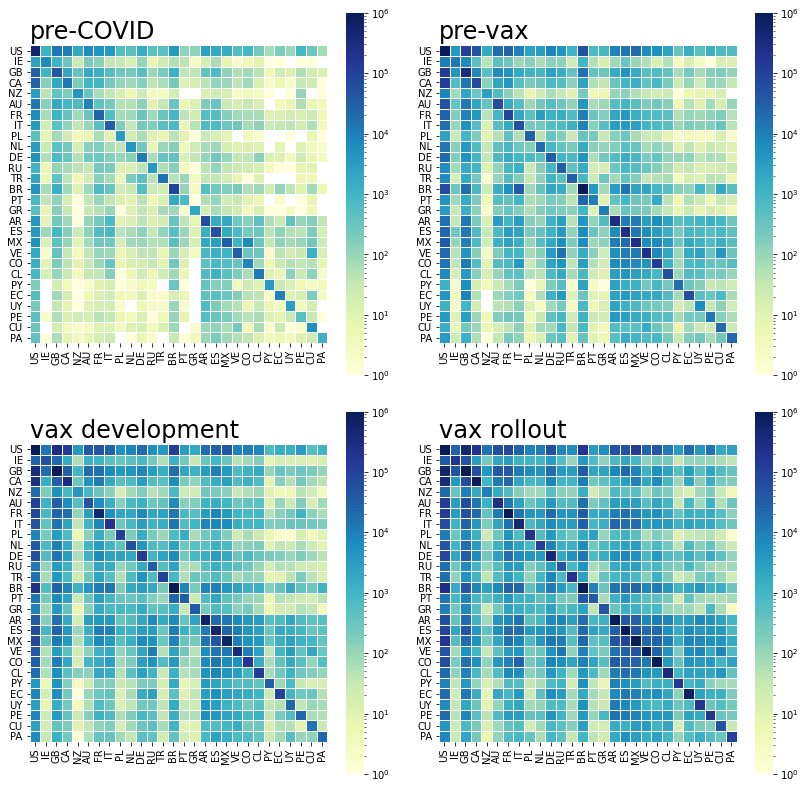

In [92]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 14))   
#adjust the space between subplots
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
#fontsize of the characters in the different parts of the plots
supylab_fsize = 28
supxlab_fsize = 28
ylab_fsize = 24
xlab_fsize = 24
ticks_fsize = 14
cbar_fsize = 22

for ax, period, period_name in zip(axes.ravel(), periods, periods_names):
    M = country_edgelists.query("period == @period")["weight"] \
                                           .unstack().fillna(0)
    
    #cbar_ax.yaxis.set_ticklabels([])
    #cbar_ax.xaxis.set_ticklabels([])
    #cbar_ax.tick_params(labelsize = cbar_fsize) 


    sns.heatmap(M.loc[lang_sort, lang_sort], 
                cmap = "YlGnBu",
                norm = LogNorm(vmax = 10 ** 6, vmin = 1),
                linewidths = 0.5, #cbar = period == "period4",
                ax = ax,# cbar_ax = cbar_ax, 
                square = True)

    ax.set_xlabel("", fontsize = 20)
    ax.set_ylabel("", fontsize = 20)
    ax.set_title(period_name, loc = "left", fontsize = xlab_fsize)


We can see that the number of interactions are inrceasing over time, and most of the retweets are in the diagonal.
### Without Diagonal
Let us exclude the diagonal, to focus on the cross-countries retweets.

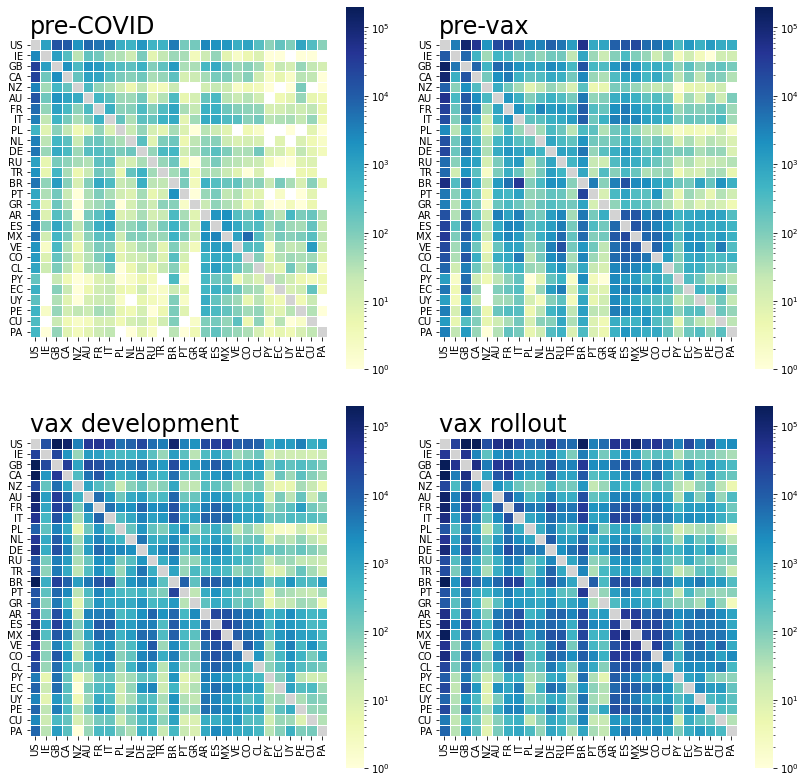

In [91]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 14))   
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)

supylab_fsize = 28
supxlab_fsize = 28
ylab_fsize = 24
xlab_fsize = 24
ticks_fsize = 14
cbar_fsize = 22

for ax, period, period_name in zip(axes.ravel(), periods, periods_names):
    M = country_edgelists.query("period == @period")["weight"] \
                                           .unstack().fillna(0)
    
    for u in M.columns:
        M.loc[u,u] = -1
    #cbar_ax.yaxis.set_ticklabels([])
    #cbar_ax.xaxis.set_ticklabels([])
    #cbar_ax.tick_params(labelsize = cbar_fsize) 


    sns.heatmap(M.loc[lang_sort, lang_sort], 
                cmap = "YlGnBu",
                norm = LogNorm(vmax = 10 ** 5.3, vmin = 1),
                linewidths = 0.5, 
                ax = ax, 
                square = True)
    
    sns.heatmap(M.loc[lang_sort, lang_sort], 
                mask = M > -0.1,
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]),
                cbar = False, ax = ax, square = True)


    ax.set_xlabel("", fontsize = 20)
    ax.set_ylabel("", fontsize = 20)
    ax.set_title(period_name, loc = "left", fontsize = xlab_fsize)


## Normalization

**Normalized adjacency matrix**: given the adjacency matrix $a_{ij}$, it is $n_{ij}$ = $a_{ij} * \sum_{hk} a_{hk}$ / ($s^{in}_{j} * s^{out}_{i}$), where $s^{out}_{i}$ = $\sum_k a_{kj}$ is the out-strength of $i$ and $s^{in}_{j}$ = $\sum_k a_{ik}$, is the in-strength of $j$.

($s^{in}_{j} * s^{out}_{i}$) / $\sum_{hk} a_{hk}$ represents the expected weight of edge $ij$ given the out-strength of $i$ and the in-strength of $j$.

In this way, we can assess the strength of the interactions between two countries, with respect to their size.



In [93]:
def matrix_normalization(A):
    M = A.copy()
    #all the outstrengths
    cols = A.sum()
    #all the instrengths
    rows = A.sum(axis = 1)
    #total number of retweets
    tot = A.sum().sum()
    for j in M.columns:
        for i in M.index:
            M.loc[i,j] = ((A.loc[i,j]) * tot ) / (cols[i] * rows[j])
    return M

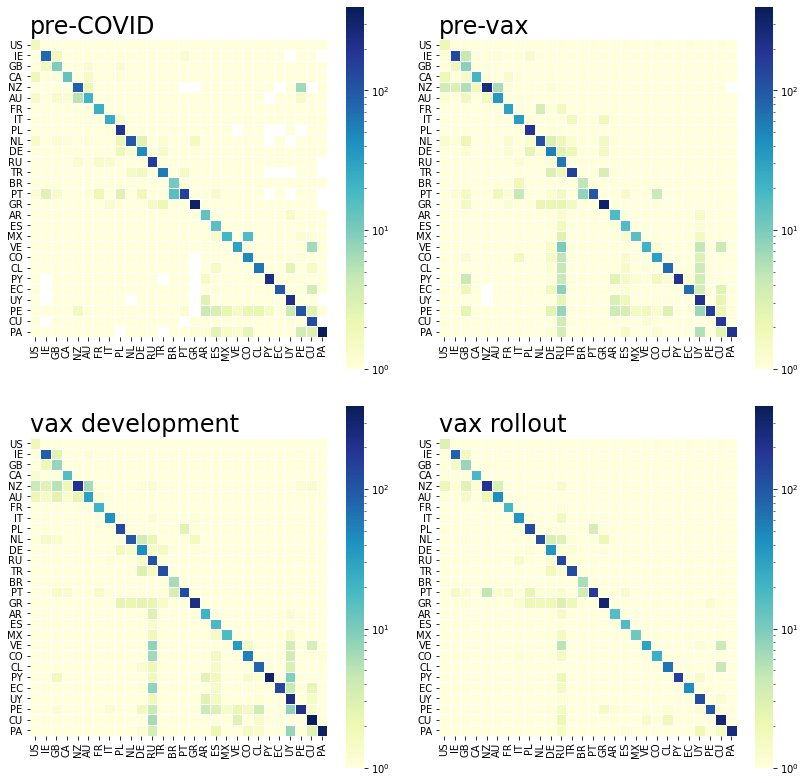

In [99]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 14))   
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)

supylab_fsize = 28
supxlab_fsize = 28
ylab_fsize = 24
xlab_fsize = 24
ticks_fsize = 14
cbar_fsize = 22

for ax, period, period_name in zip(axes.ravel(), periods, periods_names):
    M = matrix_normalization(country_edgelists.query("period == @period")["weight"] \
                             .unstack().fillna(0))
    
    #cbar_ax.yaxis.set_ticklabels([])
    #cbar_ax.xaxis.set_ticklabels([])
    #cbar_ax.tick_params(labelsize = cbar_fsize) 


    sns.heatmap(M.loc[lang_sort, lang_sort], 
                cmap = "YlGnBu",
                norm = LogNorm(vmax = 10**2.6, vmin = 1),
                linewidths = 0.5, 
                ax = ax, 
                square = True)
    
    

    ax.set_xlabel("", fontsize = 20)
    ax.set_ylabel("", fontsize = 20)
    ax.set_title(period_name, loc = "left", fontsize = xlab_fsize)


Elements in the diagonal are too dark, we can't appreciate the differences among the other patches.

This means that internal retweets are extremely more likely than cross-country ones.

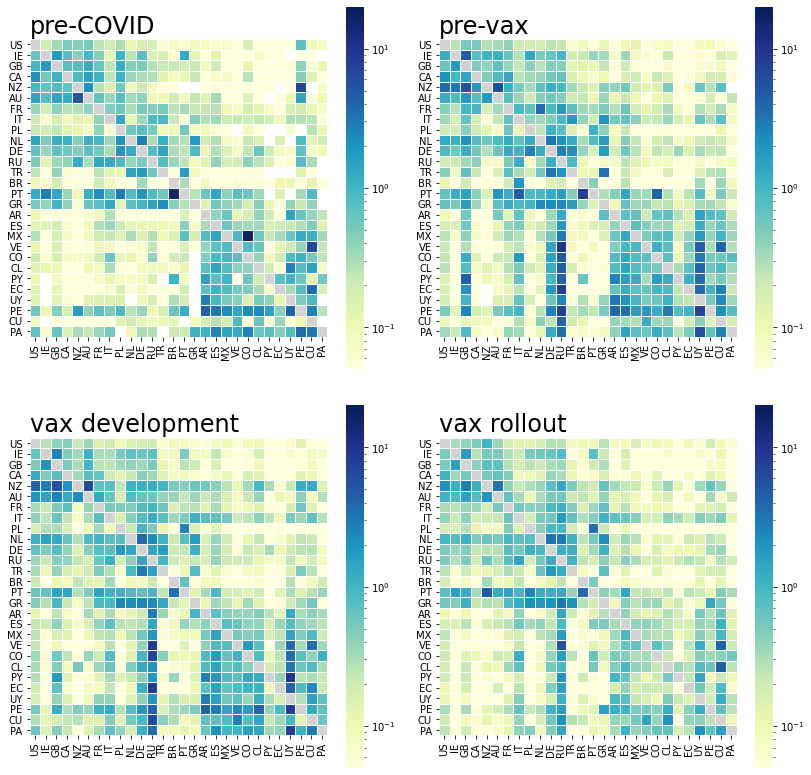

In [102]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 14))   
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)

supylab_fsize = 28
supxlab_fsize = 28
ylab_fsize = 24
xlab_fsize = 24
ticks_fsize = 14
cbar_fsize = 22

for ax, period, period_name in zip(axes.ravel(), periods, periods_names):
    M = matrix_normalization(country_edgelists.query("period == @period")["weight"] \
                             .unstack().fillna(0))
    
    for u in M.columns:
        M.loc[u,u] = -1
    #cbar_ax.yaxis.set_ticklabels([])
    #cbar_ax.xaxis.set_ticklabels([])
    #cbar_ax.tick_params(labelsize = cbar_fsize) 


    sns.heatmap(M.loc[lang_sort, lang_sort], 
                cmap = "YlGnBu",
                norm = LogNorm(vmax = 10**1.3, vmin = 10**-1.3),
                linewidths = 0.5, 
                ax = ax, 
                square = True)
    
    sns.heatmap(M.loc[lang_sort, lang_sort], 
                mask = M > -0.1,
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]),
                cbar = False, ax = ax, square = True)


    ax.set_xlabel("", fontsize = 20)
    ax.set_ylabel("", fontsize = 20)
    ax.set_title(period_name, loc = "left", fontsize = xlab_fsize)


Here we excluded the diagonal and changed the scale.
- **Language Homophily**: the top-left (English speaking countries) and bottom-right (Spanish speaking) squares are quite darker
- **Cultural Homophily**: some pairs of countries are darker, reflecting other kind of connection: Germany-the Netherlands, Germany-Turkey
- **Asimmetry**: some columns are darker than the correspondent rows (and vice versa), suggesting that information flows have a preferred direction. English countries tend to retweet much less than the opposite, also Russia is an information exporter
- **US**: they export information all over the world in the four periods, having a complete coloured column
- **Russia**: from pre-vax period (Sputnik V vaccine was announced in August and supplied to manny South American countries) Russia column is very dark in the bottom part, suggesting a strong retweets out-flow to South American countries

## Countries in-strength vs out-strength
Now we compare the in-strengths and out-strengths of each country, to notice which countries are stronger exporter of retweets.

In [112]:
#compute in-/out-strengths as sum of the in-/out-weight of the links to each other country
out_strength = country_edgelists.reset_index().groupby(["country", "period"]).sum().rename(columns = {"weight": "strength"})
in_strength = country_edgelists.reset_index().groupby(["country_RT", "period"]).sum().rename(columns = {"weight": "strength"})

In [113]:
strengths = out_strength.merge(in_strength,
                               left_index = True, right_index = True, suffixes = ["_out", "_in"]) \
.query("country == country_RT")
strengths.head()

strength_out  strength_in
period  country country_RT                           
period1 AR      AR               78794.0      80699.0
        AU      AU               27196.0      20535.0
        BR      BR              107272.0     110226.0
        CA      CA               46211.0      30934.0
        CL      CL               17281.0      15349.0

<ipython-input-120-007a28ae2a53>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


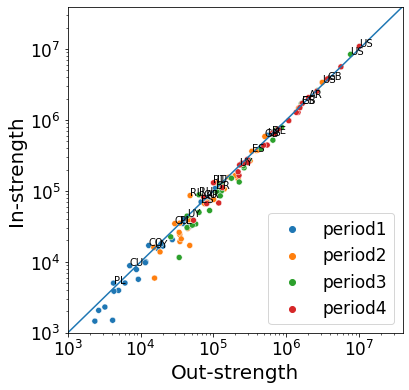

In [120]:
fig, axes = plt.subplots(1,1, figsize = (6, 6))

#create a scatterplot where each point has x-coordinate out-strength and y in-strength, coloured by period
sns.scatterplot(data = strengths,
                x = "strength_out", y = "strength_in", hue = "period")
#draw the diagonal to note which countries are exporters and which importers
sns.lineplot(x = [10**1, 10**10], y = [10**1, 10**10])

#flag the nodes with in-strength > out-strength
for (_, country, _), (x, y) in strengths.query("strength_in > strength_out").iterrows():
    axes.text(x, y, country) 

axes.set_xlabel("Out-strength", fontsize = 20)
axes.set_ylabel("In-strength", fontsize = 20)
    
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim([10**3, 10**7.6])
axes.set_ylim([10**3, 10**7.6])

plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
axes.legend(loc = "lower right", fontsize = 17)


fig.show()

The plot is too squeezed on the diagonal, because internal reweets are too prominent (and they are counted both as in-links and out-links).

I remove the internal retweets and plot the same scatterplot.

In [126]:
#compute in-/out-strengths as sum of the in-/out-weight of the links to each other country
out_strength = country_edgelists.query("country != country_RT").reset_index().groupby(["country", "period"]).sum().rename(columns = {"weight": "strength"})
in_strength = country_edgelists.query("country != country_RT").reset_index().groupby(["country_RT", "period"]).sum().rename(columns = {"weight": "strength"})

In [127]:
strengths = out_strength.merge(in_strength,
                               left_index = True, right_index = True, suffixes = ["_out", "_in"]) \
.query("country == country_RT")
strengths.head()

strength_out  strength_in
period  country country_RT                           
period1 AR      AR               11130.0      13035.0
        AU      AU               18373.0      11712.0
        BR      BR                9773.0      12727.0
        CA      CA               31546.0      16269.0
        CL      CL                4392.0       2460.0

<ipython-input-131-b5d73f3ad4ff>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


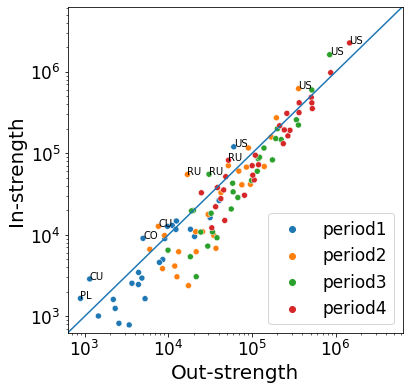

In [131]:
fig, axes = plt.subplots(1,1, figsize = (6, 6))

#create a scatterplot where each point has x-coordinate out-strength and y in-strength, coloured by period
sns.scatterplot(data = strengths,
                x = "strength_out", y = "strength_in", hue = "period")
#draw the diagonal to note which countries are exporters and which importers
sns.lineplot(x = [10**1, 10**10], y = [10**1, 10**10])

#flag the nodes with in-strength > out-strength
for (_, country, _), (x, y) in strengths.query("strength_in > 1.5 * strength_out").iterrows():
    axes.text(x, y, country) 

axes.set_xlabel("Out-strength", fontsize = 20)
axes.set_ylabel("In-strength", fontsize = 20)
    
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim([10**2.8, 10**6.8])
axes.set_ylim([10**2.8, 10**6.8])

plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
axes.legend(loc = "lower right", fontsize = 17)


fig.show()

- **Time evolution**: the heights of the points follows the time period, with red points on the top-right and blue ones on bottom-left
- **US**: is quite far from the diagonal in all periods, confirming its role of superspreader
- **Russia**: is quite far from diagonal from 2nd period